#### Import the relevant packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.exceptions import FitFailedWarning

#### Step 1: Load Data & Data Preprocessing

In [2]:
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data/Pre_Processed_Data_All_Locaions_Updated_1.csv"
Complete_Data = pd.read_csv(data_path)

Complete_Data['Date'] = pd.to_datetime(Complete_Data['Date'], format='%Y-%m-%d')
Complete_Data['Source_ID'] = Complete_Data['Source'].astype('category').cat.codes + 1
filtered_df = Complete_Data.drop(columns=[
    'Day_of_Year', 'Available_soil_storage_mm', 'Source',
    'SWCT_005', 'STMP_005', 'NEE_CO2', 'NEE_CO2_MDS', 
    'NEE_CH4', 'NEE_CH4_MDS', 'NEE_H2O'])

# Scale the target variable 'SWCT_015' for easier model interpretation
filtered_df['SWCT_015'] = filtered_df['SWCT_015'] / 100

# Define feature set 'X' (independent variables) and target 'y' (dependent variable)
X = filtered_df.drop(columns=["SWCT_015", "Date"])  # Drop the target variable and 'Date' column from features
y = filtered_df["SWCT_015"]                         # Define target variable
groups = filtered_df["Source_ID"]                   # Group identifier for LOGO CV

# Check and handle NaN values in `y` before splitting the data
print("Checking for NaN values in y before splitting:")
if y.isna().any():
    print(f"Found {y.isna().sum()} NaN values in y. Removing corresponding rows.")
    # Drop rows with NaN values in y and adjust X and groups accordingly
    non_na_indices = y.dropna().index
    X = X.loc[non_na_indices]
    y = y.loc[non_na_indices]
    groups = groups.loc[non_na_indices]
else:
    print("No NaN values found in y.")

# Proceed with splitting the data
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42)

# Print dimensions after handling NaNs and splitting
print("Data shapes after NaN handling and splitting:")
print("X_train no. of columns & rows:", X_train.shape)
print("y_train no. of columns & rows:", y_train.shape)
print("X_test no. of columns & rows:", X_test.shape)
print("y_test no. of columns & rows:", y_test.shape)
print("groups_train no. of columns & rows:", groups_train.shape)
print("groups_test no. of columns & rows:", groups_test.shape)

# Initial check: Store initial index order before handling NaNs
initial_indices = X_train.index

# Handle any missing values in the target variable (y_train) as SequentialFeatureSelector cannot process NaNs
initial_y_train_size = y_train.shape[0]  # Store the initial size of y_train for comparison
if y_train.isna().any():
    # Drop rows where y_train has NaN values, adjusting X_train and groups_train accordingly
    non_na_indices = y_train.dropna().index
    X_train = X_train.loc[non_na_indices]
    y_train = y_train.loc[non_na_indices]
    groups_train = groups_train.loc[non_na_indices]

    # Confirm action by comparing initial and new sizes
    print(f"Rows removed due to NaNs in y_train: {initial_y_train_size - y_train.shape[0]}")
else:
    print("No NaN values were found in y_train; no rows removed.")

# Double-check and print the new dimensions of X_train, y_train, and groups_train
print("\nNew X_train shape after NaN handling:", X_train.shape)
print("New y_train shape after NaN handling:", y_train.shape)
print("New groups_train shape after NaN handling:", groups_train.shape)

# Verify alignment by checking index equality between X_train, y_train, and groups_train
if X_train.index.equals(y_train.index) and X_train.index.equals(groups_train.index):
    print("\nRows in X_train, y_train, and groups_train remain aligned.")
else:
    print("\nWarning: Rows in X_train, y_train, and groups_train are misaligned!")

Checking for NaN values in y before splitting:
Found 27643 NaN values in y. Removing corresponding rows.
Data shapes after NaN handling and splitting:
X_train no. of columns & rows: (6858, 11)
y_train no. of columns & rows: (6858,)
X_test no. of columns & rows: (1715, 11)
y_test no. of columns & rows: (1715,)
groups_train no. of columns & rows: (6858,)
groups_test no. of columns & rows: (1715,)
No NaN values were found in y_train; no rows removed.

New X_train shape after NaN handling: (6858, 11)
New y_train shape after NaN handling: (6858,)
New groups_train shape after NaN handling: (6858,)

Rows in X_train, y_train, and groups_train remain aligned.


#### Step 2: Run Sequential Feature Selector 

In [3]:
# Initialize RandomForestRegressor for feature selection
rf_for_selection = RandomForestRegressor(random_state=0)
logo = LeaveOneGroupOut()  # Set up Leave-One-Group-Out cross-validator based on unique data sources

# Step 1: Run Sequential Feature Selector to identify the optimal subset of features
feature_selector = SequentialFeatureSelector(
    rf_for_selection,
    n_features_to_select="auto",                          # Let the model select the optimal number of features automatically
    direction="backward",                                 # Remove least impactful features one by one
    scoring="neg_mean_squared_error",                     # Scoring based on MSE, as it is a regression problem
    cv=logo.split(X_train, y_train, groups=groups_train), # Apply LOGO CV
    n_jobs=-1)                                            # Use all available cores

# Fit the feature selector on the training data and transform both training and test sets
feature_selector.fit(X_train, y_train)
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

# Get selected features
selected_features = X_train.columns[feature_selector.get_support()]  # Get column names of selected features
print("Selected Features:", selected_features.tolist())              # Display the selected feature names

Selected Features: ['S2_NDMI', 'L8_9_LST', 'MODIS_LAI', 'STMP_015', 'ATMP', 'Source_ID']


#### Step 3: Initialize & Fit GridSearchCV for tuning hyperparameters

In [4]:
# Define the final model and pipeline for hyperparameter tuning with selected features
rf = RandomForestRegressor(random_state=0)  # Re-initialize RandomForestRegressor for the pipeline
pipeline = Pipeline([("randomforestregressor", rf)])

# Define a parameter grid for tuning hyperparameters of the RandomForest model
param_grid = {
    "randomforestregressor__n_estimators": [50, 100, 150],        # Number of trees in the forest
    "randomforestregressor__max_depth": [5, 10, 15],              # Maximum depth of each tree
    "randomforestregressor__max_features": ["sqrt", "log2",None], # Number of features to consider per split
    "randomforestregressor__min_samples_leaf": [1, 2, 4]}         # Minimum samples per leaf node

# Suppress all warnings except FitFailedWarning to focus on errors during fitting
warnings.simplefilter("error", FitFailedWarning)

# Initialize GridSearchCV with error_score='raise' to investigate failed fits
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=logo.split(X_train_selected, y_train, groups=groups_train),  # Apply LOGO on reduced feature set
    scoring="neg_mean_squared_error",   # Optimize for negative MSE
    n_jobs=-1,
    error_score='raise')  # Raise errors for failed fits

# Fit GridSearchCV on the selected features in the training set with error handling
try:
    grid_search.fit(X_train_selected, y_train)
except FitFailedWarning as e:
    print("FitFailedWarning encountered:")
    print(str(e))  # Print the detailed error message
except ValueError as ve:
    print("ValueError encountered during fitting:")
    print(str(ve))  # Print ValueError details, which may reveal specific issues with NaNs or misaligned data

# Display best parameters and cross-validation score found during tuning
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 150}
Best Cross-Validation Score: -0.008744575523664212


#### Step 4: Generate predictions using the best model

In [5]:
# Generate predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

# Check for NaN values in y_test and y_pred
if np.isnan(y_test).any():
    print("Warning: y_test contains NaN values.")
else:
    print("y_test does not contain NaN values.")

if np.isnan(y_pred).any():
    print("Warning: y_pred contains NaN values.")
else:
    print("y_pred does not contain NaN values.")

# If both y_test and y_pred are free of NaNs, proceed with metric calculation
if not np.isnan(y_test).any() and not np.isnan(y_pred).any():
    print("Test Set R^2 Score:", r2_score(y_test, y_pred))                # R^2 Score
    print("Test Set RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))  # Root Mean Squared Error
    print("Test Set MAE:", mean_absolute_error(y_test, y_pred))           # Mean Absolute Error
else:
    print("Evaluation metrics could not be calculated due to NaN values in y_test or y_pred.")

y_test does not contain NaN values.
y_pred does not contain NaN values.
Test Set R^2 Score: 0.7000983639696646
Test Set RMSE: 0.08621322407548321
Test Set MAE: 0.0571486362925853


#### Step 5: Plotting a summary plot using shapley values

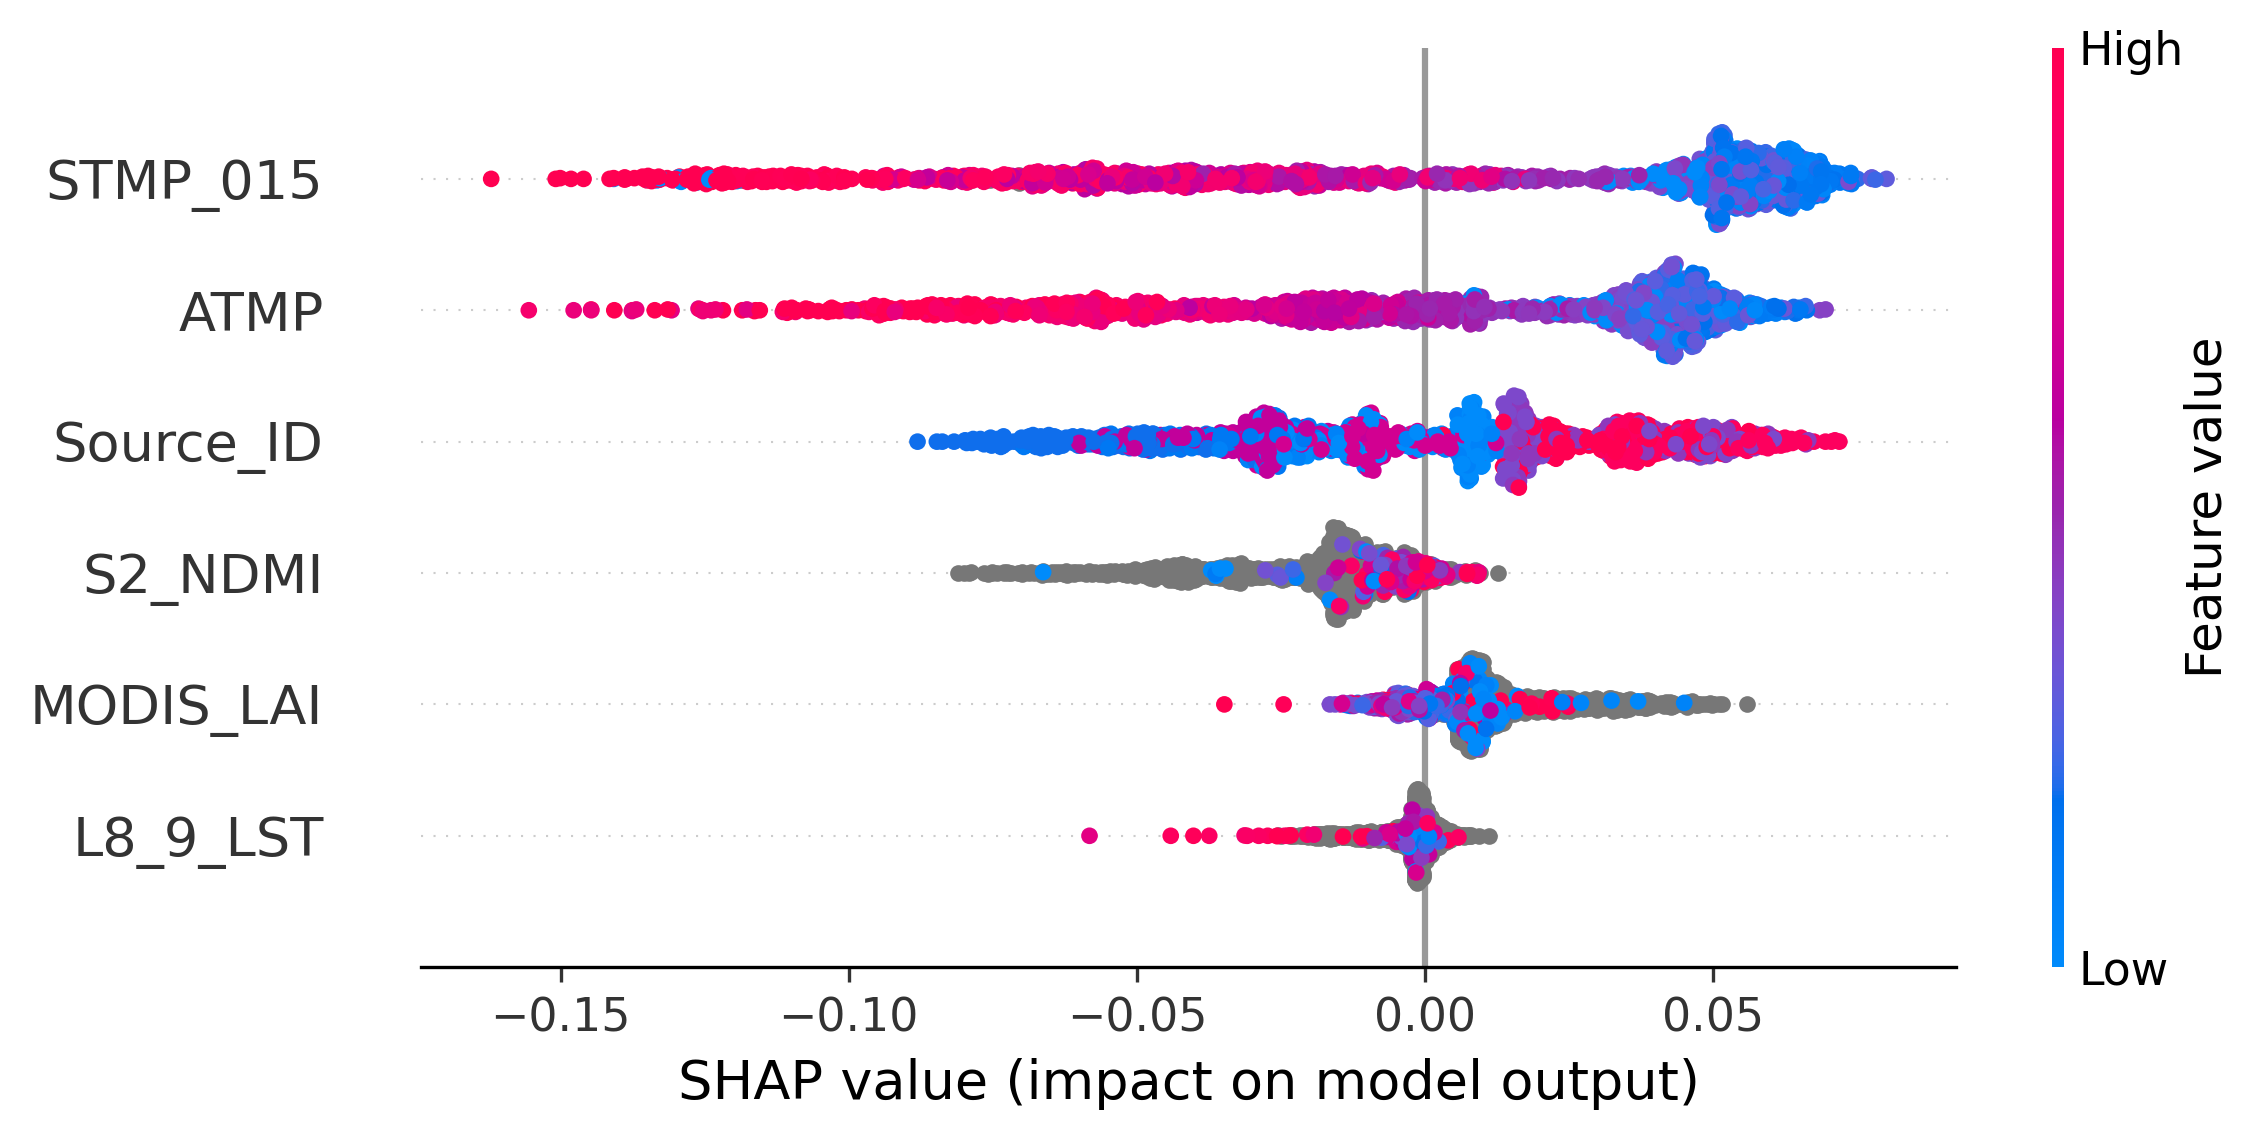

In [6]:
# Extract the RandomForest model from the pipeline
rf_model = best_model.named_steps["randomforestregressor"]

# Initialize SHAP explainer for the extracted model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test data with selected features
shap_values = explainer.shap_values(X_test_selected)

plt.figure(dpi=300, figsize=(12, 8))

# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, show=False)

# Save the plot 
#plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches="tight")  # Save as PNG file
#plt.close()

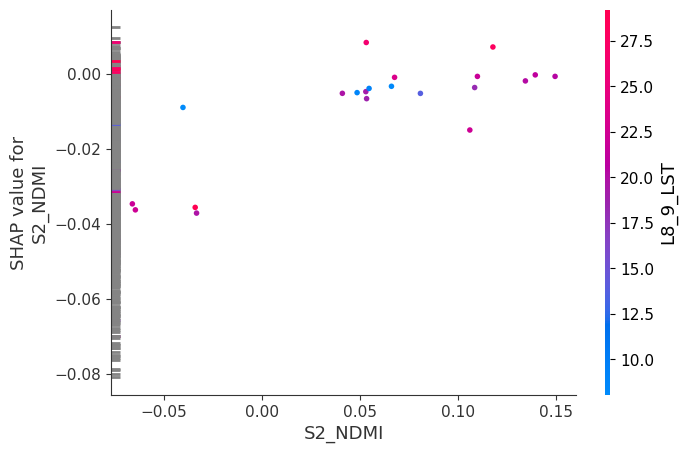

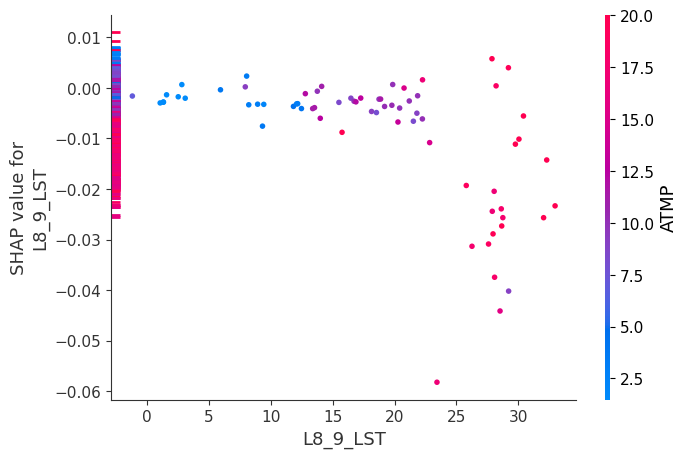

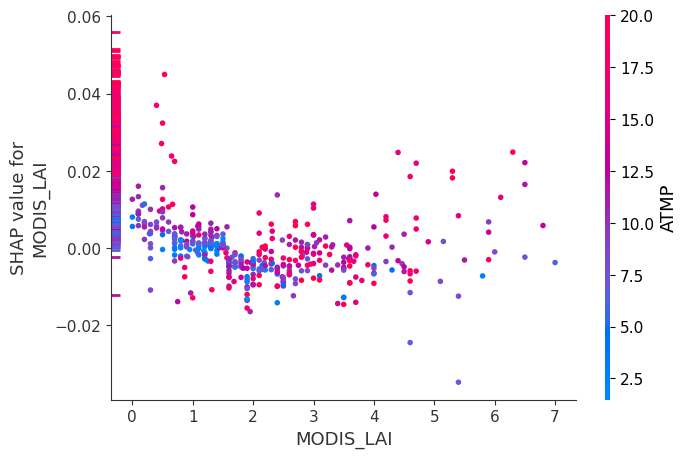

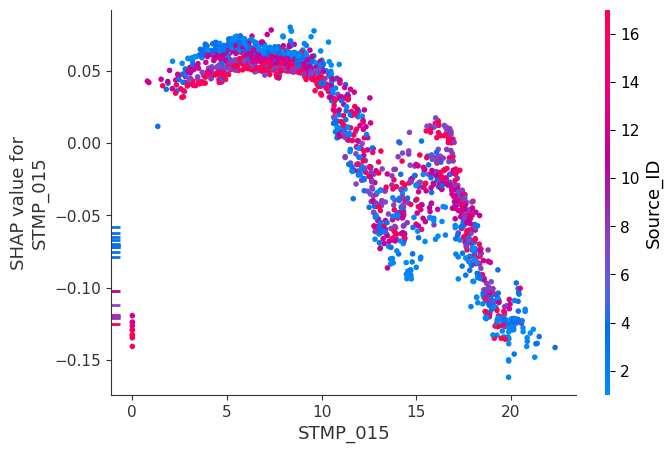

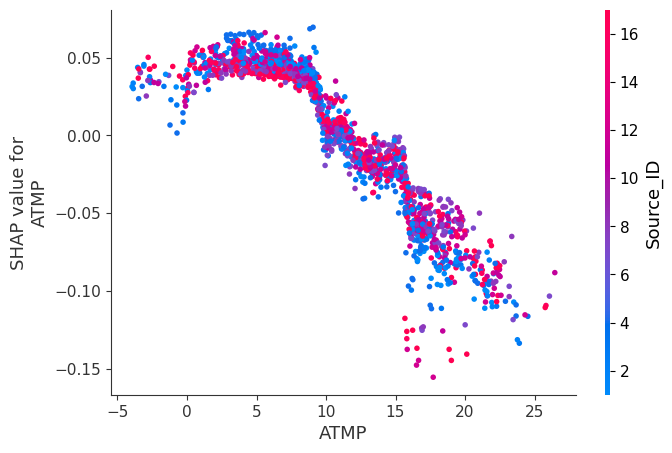

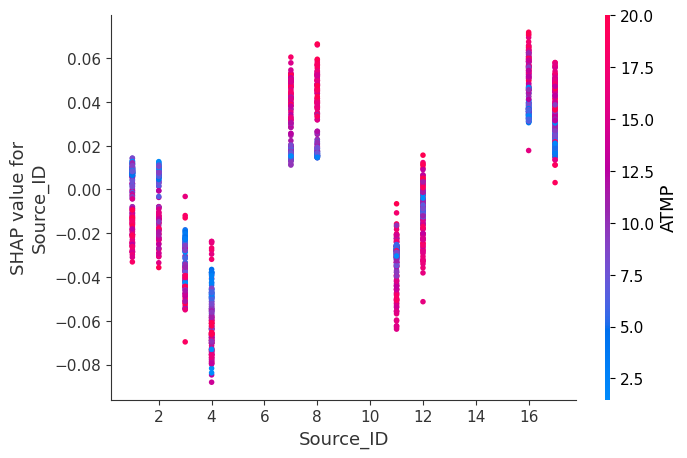

In [7]:
# Loop through each feature and create a scatter plot
for feature_name in selected_features:
    shap.dependence_plot(
        feature_name,        # Feature to plot
        shap_values,         # SHAP values
        X_test_selected,     # Data on which SHAP values were computed
        feature_names=selected_features
    )